## 1. Data Loading

In [39]:
import os
import sys
import json

from tqdm.notebook import tqdm

import math

import pandas as pd
pd.set_option('display.max_columns', None)

from io import BytesIO
from pathlib import Path

from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
# optional: if you get a SSL CERTIFICATE_VERIFY_FAILED exception
import ssl; ssl._create_default_https_context = ssl._create_unverified_context

from zipfile import ZipFile, is_zipfile

import socceraction.spadl as spadl
import socceraction.spadl.wyscout as wyscout

import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen, VerticalPitch

Define function to read JSON files

In [2]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

Import competitions, we may needs this for extra info about the competition

In [3]:
competitions_url = 'Wyscout/'

json_competitions = read_json_file(f"{competitions_url}/competitions.json")
df_competitions = pd.read_json(json_competitions)
df_competitions['name'] = df_competitions.apply(lambda x: x.area['name'] if x.area['name'] != "" else x['name'], axis=1)
#df_competitions['id'] = df_competitions.apply(lambda x: leagues.get(x.area['name'], 'NULL'), axis=1)
# View all available competitions
set(df_competitions.name)

/var/folders/1r/56nf11_90f52p5v071j9flwr0000gp/T/ipykernel_767/1022753461.py:4: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_competitions = pd.read_json(json_competitions)


{'England',
 'European Championship',
 'France',
 'Germany',
 'Italy',
 'Spain',
 'World Cup'}

In [4]:
df_competitions[df_competitions["name"] == 'Germany']

,name,wyId,format,area,type
4,Germany,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club


In [5]:
df_competitions["competition_id"] = df_competitions["wyId"]
df_competitions = df_competitions.drop(columns=["wyId"])

In [6]:
df_competitions

,name,format,area,type,competition_id
0,Italy,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club,524
1,England,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,364
2,Spain,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club,795
3,France,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club,412
4,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,426
5,European Championship,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,102
6,World Cup,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,28


Import Player and Team Data, we can enrich event data with extra information this way

In [7]:
team_path = 'Wyscout/'
player_path = 'Wyscout/'

json_teams = read_json_file(f"{team_path}/teams.json")
df_teams = pd.read_json(json_teams)

json_players = read_json_file(f"{player_path}/players.json")
df_players = pd.read_json(json_players)

/var/folders/1r/56nf11_90f52p5v071j9flwr0000gp/T/ipykernel_767/386936293.py:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_teams = pd.read_json(json_teams)
/var/folders/1r/56nf11_90f52p5v071j9flwr0000gp/T/ipykernel_767/386936293.py:8: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_players = pd.read_json(json_players)


In [8]:
df_players[df_players["currentTeamId"]==2975]

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
10,"{'name': 'Austria', 'id': '40', 'alpha3code': ...",74,Marcel,,Sabitzer,2975,1994-03-17,177,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Austria', 'id': '40', 'alpha3code': ...",65596,right,M. Sabitzer,null
95,"{'name': 'Brazil', 'id': '76', 'alpha3code': '...",76,Bernardo,,Fernandes da Silva Junior,2975,1995-05-14,186,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Brazil', 'id': '76', 'alpha3code': '...",296341,left,Bernardo,null
529,"{'name': 'Portugal', 'id': '620', 'alpha3code'...",70,Armindo,,Tué Na Bangna,2975,1994-10-24,173,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Guinea-Bissau', 'id': '624', 'alpha3...",70975,right,Bruma,null
558,"{'name': 'Austria', 'id': '40', 'alpha3code': ...",72,Konrad,,Laimer,2975,1997-05-27,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Austria', 'id': '40', 'alpha3code': ...",282804,right,K. Laimer,9116
763,"{'name': 'Germany', 'id': '276', 'alpha3code':...",75,Timo,,Werner,2975,1996-03-06,180,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Germany', 'id': '276', 'alpha3code':...",173214,right,T. Werner,3148
772,"{'name': 'Hungary', 'id': '348', 'alpha3code':...",83,Péter,,Gulácsi,2975,1990-05-06,190,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Hungary', 'id': '348', 'alpha3code':...",9611,right,P. Gulácsi,10451
937,"{'name': 'Nigeria', 'id': '566', 'alpha3code':...",78,Ademola,,Lookman,2975,1998-07-18,174,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'England', 'id': '0', 'alpha3code': '...",406682,right,A. Lookman,null
1103,"{'name': 'Hungary', 'id': '348', 'alpha3code':...",82,Willi,,Orban,2975,1992-11-03,186,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",15069,right,W. Orban,null
1192,"{'name': 'Germany', 'id': '276', 'alpha3code':...",67,Dominik,,Kaiser,2975,1988-09-16,171,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",15810,right,D. Kaiser,null


In [9]:
df_players["player_id"] = df_players["wyId"]
df_players = df_players.drop(columns=["wyId"])

In [10]:
df_teams[df_teams["name"]=="RB Leipzig"]

,city,name,wyId,officialName,area,type
83,Leipzig,RB Leipzig,2975,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club


In [11]:
df_teams["team_id"] = df_teams["wyId"]
df_teams = df_teams.drop(columns=["wyId"])
df_teams.head()

,city,name,officialName,area,type,team_id
0,Newcastle upon Tyne,Newcastle United,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,1613
1,Vigo,Celta de Vigo,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club,692
2,Barcelona,Espanyol,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club,691
3,Vitoria-Gasteiz,Deportivo Alavés,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club,696
4,Valencia,Levante,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club,695


Load Matches Data

In [12]:
# Define the path to the matches directory
data_path = 'Wyscout/matches'

# Load match data from a specific league or competition
match_files = os.listdir(data_path)

matches = []
for file in match_files:
    file_path = os.path.join(data_path, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        matches.extend(data)

# Convert the list of matches to a DataFrame
df_matches = pd.DataFrame(matches)

print(f"Loaded {len(matches)} matches")
print(df_matches.head())  # Display the first few rows of the DataFrame

Loaded 1941 matches
   status  roundId  gameweek  \
0  Played  4165368         0   
1  Played  4165367         0   
2  Played  4165366         0   
3  Played  4165366         0   
4  Played  4165365         0   

                                           teamsData  seasonId  \
0  {'9598': {'scoreET': 0, 'coachId': 122788, 'si...     10078   
1  {'2413': {'scoreET': 0, 'coachId': 276858, 'si...     10078   
2  {'2413': {'scoreET': 1, 'coachId': 276858, 'si...     10078   
3  {'5629': {'scoreET': 0, 'coachId': 8605, 'side...     10078   
4  {'14358': {'scoreET': 2, 'coachId': 264893, 's...     10078   

               dateutc  winner                         venue     wyId  \
0  2018-07-15 15:00:00    4418  Olimpiyskiy stadion Luzhniki  2058017   
1  2018-07-14 14:00:00    5629           Stadion Krestovskyi  2058016   
2  2018-07-11 18:00:00    9598  Olimpiyskiy stadion Luzhniki  2058015   
3  2018-07-10 18:00:00    4418           Stadion Krestovskyi  2058014   
4  2018-07-07 18:00:00   

In [13]:
df_matches[df_matches["competitionId"]==426].tail(20)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,groupName,referees,duration,competitionId
730,Played,4405517,3,"{'2455': {'scoreET': 0, 'coachId': 19925, 'sid...",181137,2017-09-09 13:30:00,0,VOLKSWAGEN ARENA,2516765,"Wolfsburg - Hannover 96, 1 - 1","September 9, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 384952, 'role': 'referee'}, {'r...",Regular,426
731,Played,4405517,3,"{'2450': {'scoreET': 0, 'coachId': 259751, 'si...",181137,2017-09-08 18:30:00,2975,Volksparkstadion,2516763,"Hamburger SV - RB Leipzig, 0 - 2","September 8, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 384973, 'role': 'referee'}, {'r...",Regular,426
732,Played,4405517,2,"{'2455': {'scoreET': 0, 'coachId': 19925, 'sid...",181137,2017-08-27 16:00:00,2455,HDI-Arena,2516755,"Hannover 96 - Schalke 04, 1 - 0","August 27, 2017 at 6:00:00 PM GMT+2",NaN,"[{'refereeId': 379378, 'role': 'referee'}, {'r...",Regular,426
733,Played,4405517,2,"{'2453': {'scoreET': 0, 'coachId': 14977, 'sid...",181137,2017-08-27 13:30:00,2975,Red Bull Arena,2516749,"RB Leipzig - Freiburg, 4 - 1","August 27, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 383491, 'role': 'referee'}, {'r...",Regular,426
734,Played,4405517,2,"{'2457': {'scoreET': 0, 'coachId': 18987, 'sid...",181137,2017-08-26 16:30:00,2447,Signal-Iduna-Park,2516748,"Borussia Dortmund - Hertha BSC, 2 - 0","August 26, 2017 at 6:30:00 PM GMT+2",NaN,"[{'refereeId': 381840, 'role': 'referee'}, {'r...",Regular,426
735,Played,4405517,2,"{'2443': {'scoreET': 0, 'coachId': 261672, 'si...",181137,2017-08-26 13:30:00,2444,Weserstadion,2516751,"Werder Bremen - Bayern M\u00fcnchen, 0 - 2","August 26, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 378957, 'role': 'referee'}, {'r...",Regular,426
736,Played,4405517,2,"{'2451': {'scoreET': 0, 'coachId': 145007, 'si...",181137,2017-08-26 13:30:00,2451,Commerzbank-Arena,2516752,"Eintracht Frankfurt - Wolfsburg, 0 - 1","August 26, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 383336, 'role': 'referee'}, {'r...",Regular,426
737,Played,4405517,2,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-26 13:30:00,0,BayArena,2516753,"Bayer Leverkusen - Hoffenheim, 2 - 2","August 26, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 385544, 'role': 'referee'}, {'r...",Regular,426
738,Played,4405517,2,"{'2454': {'scoreET': 0, 'coachId': 15114, 'sid...",181137,2017-08-26 13:30:00,0,WWK Arena,2516754,"Augsburg - Borussia M'gladbach, 2 - 2","August 26, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 379444, 'role': 'referee'}, {'r...",Regular,426
739,Played,4405517,2,"{'2460': {'scoreET': 0, 'coachId': 228372, 'si...",181137,2017-08-26 13:30:00,2445,Mercedes-Benz-Arena,2516756,"Stuttgart - Mainz 05, 1 - 0","August 26, 2017 at 3:30:00 PM GMT+2",NaN,"[{'refereeId': 381858, 'role': 'referee'}, {'r...",Regular,426


In [14]:
df_matches["match_id"]= df_matches["wyId"] 
df_matches = df_matches.drop(columns=["wyId"])

Load Event Data

In [15]:
event_path = 'Wyscout/events/events_Germany.json'

json_events = read_json_file(event_path)
df_events = pd.read_json(json_events)

/var/folders/1r/56nf11_90f52p5v071j9flwr0000gp/T/ipykernel_767/1673591395.py:4: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_events = pd.read_json(json_events)


In [16]:
df_events

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446
...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790


## 2. Data joining & Cleaning

In [17]:
df_events["player_id"] = df_events["playerId"] 
df_events["match_id"] = df_events["matchId"] 
df_events["team_id"] = df_events["teamId"] 

df_events = df_events.drop(columns=["matchId", "teamId", "playerId"])

In [18]:
df_events_teams = pd.merge(df_events, df_teams, on='team_id', how='left')

In [19]:
df_events_teams[df_events_teams["player_id"]==393247]

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name,officialName,area,type
89467,8,Simple pass,[{'id': 1801}],"[{'y': 48, 'x': 17}, {'y': 49, 'x': 4}]",Pass,1H,14.520416,85,192631408,393247,2516793,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
89573,8,High pass,[{'id': 1802}],"[{'y': 81, 'x': 33}, {'y': 66, 'x': 71}]",Pass,1H,273.875628,83,192631541,393247,2516793,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
89582,1,Air duel,"[{'id': 703}, {'id': 1801}]","[{'y': 43, 'x': 29}, {'y': 39, 'x': 44}]",Duel,1H,316.653504,10,192631548,393247,2516793,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
89585,1,Air duel,"[{'id': 701}, {'id': 1802}]","[{'y': 34, 'x': 30}, {'y': 57, 'x': 33}]",Duel,1H,320.604777,10,192631550,393247,2516793,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
89595,8,Simple pass,[{'id': 1801}],"[{'y': 66, 'x': 21}, {'y': 84, 'x': 30}]",Pass,1H,346.988109,85,192631561,393247,2516793,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509491,8,Simple pass,[{'id': 1801}],"[{'y': 63, 'x': 28}, {'y': 89, 'x': 37}]",Pass,2H,2590.770656,85,251219625,393247,2517038,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
509495,8,Simple pass,[{'id': 1801}],"[{'y': 79, 'x': 31}, {'y': 69, 'x': 30}]",Pass,2H,2601.843303,85,251219629,393247,2517038,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
509497,8,Simple pass,[{'id': 1801}],"[{'y': 82, 'x': 34}, {'y': 69, 'x': 36}]",Pass,2H,2605.434198,85,251219631,393247,2517038,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
509499,8,Simple pass,[{'id': 1801}],"[{'y': 83, 'x': 29}, {'y': 62, 'x': 28}]",Pass,2H,2608.422279,85,251219632,393247,2517038,2975,Leipzig,RB Leipzig,Rasen Ballsport Leipzig,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club


In [20]:
df_events_teams_players = pd.merge(df_events_teams, df_players, on='player_id', how='left')

In [21]:
df_events_teams_players.tail(20)

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name,officialName,area,type,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,foot,shortName,currentNationalTeamId
519387,8,Simple pass,[{'id': 1801}],"[{'y': 28, 'x': 60}, {'y': 18, 'x': 47}]",Pass,2H,2798.169590,85,251206858,94831,2517044,2463,Köln,Köln,1. FC Köln,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Japan', 'id': '392', 'alpha3code': '...",71.0,Yūya,,Ōsako,2443,1990-05-18,182.0,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Japan', 'id': '392', 'alpha3code': '...",right,Y. Ōsako,12913
519388,8,Simple pass,[{'id': 1801}],"[{'y': 18, 'x': 47}, {'y': 36, 'x': 32}]",Pass,2H,2801.305189,85,251206859,18669,2517044,2463,Köln,Köln,1. FC Köln,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",75.0,Jonas,,Hector,2463,1990-05-27,185.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",left,J. Hector,3148
519389,8,Simple pass,[{'id': 1801}],"[{'y': 36, 'x': 32}, {'y': 62, 'x': 32}]",Pass,2H,2804.460822,85,251206860,16843,2517044,2463,Köln,Köln,1. FC Köln,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",87.0,Dominique,,Heintz,2463,1993-08-15,189.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",left,D. Heintz,null
519390,8,Simple pass,[{'id': 1801}],"[{'y': 62, 'x': 32}, {'y': 88, 'x': 66}]",Pass,2H,2807.540961,85,251206861,275384,2517044,2463,Köln,Köln,1. FC Köln,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",78.0,Jorge,,Meré Pérez,2463,1997-04-17,182.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Spain', 'id': '724', 'alpha3code': '...",right,Jorge Meré,1604
519391,8,High pass,[{'id': 1802}],"[{'y': 88, 'x': 66}, {'y': 51, 'x': 89}]",Pass,2H,2810.604426,83,251206862,15194,2517044,2463,Köln,Köln,1. FC Köln,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",75.0,Marcel,,Risse,2463,1989-12-17,183.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,M. Risse,null
519392,8,Head pass,"[{'id': 1401}, {'id': 1801}]","[{'y': 49, 'x': 11}, {'y': 50, 'x': 14}]",Pass,2H,2812.356433,82,251206779,14917,2517044,2451,Wolfsburg,Wolfsburg,VfL Wolfsburg,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",77.0,Robin,,Knoche,2451,1992-05-22,190.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,R. Knoche,null
519393,1,Air duel,"[{'id': 701}, {'id': 1802}]","[{'y': 50, 'x': 86}, {'y': 53, 'x': 78}]",Duel,2H,2814.531917,10,251206863,16094,2517044,2463,Köln,Köln,1. FC Köln,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",83.0,Simon,,Terodde,2463,1988-03-02,192.0,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,S. Terodde,null
519394,1,Air duel,"[{'id': 703}, {'id': 1801}]","[{'y': 50, 'x': 14}, {'y': 47, 'x': 22}]",Duel,2H,2814.534050,10,251206780,14917,2517044,2451,Wolfsburg,Wolfsburg,VfL Wolfsburg,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",77.0,Robin,,Knoche,2451,1992-05-22,190.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,R. Knoche,null
519395,1,Air duel,"[{'id': 701}, {'id': 1802}]","[{'y': 47, 'x': 22}, {'y': 54, 'x': 17}]",Duel,2H,2816.202197,10,251206781,337903,2517044,2451,Wolfsburg,Wolfsburg,VfL Wolfsburg,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'na

In [22]:
df_events_teams_players_matches = pd.merge(df_events_teams_players, df_matches, on='match_id', how='left')

In [23]:
df_events_teams_players_matches["competition_id"] = df_events_teams_players_matches["competitionId"]
df_events_teams_players_matches = df_events_teams_players_matches.drop(columns=["competitionId"])

In [24]:
df_events_teams_players_matches

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name,officialName,area,type,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,foot,shortName,currentNationalTeamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,label,date,groupName,referees,duration,competition_id
0,8,Simple pass,[{'id': 1801}],"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",Pass,1H,2.409746,85,179896442,15231,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",81.0,Kevin,,Volland,2446,1992-07-30,179.0,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Germany', 'id': '276', 'alpha3code':...",left,K. Volland,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426
1,8,Simple pass,[{'id': 1801}],"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",Pass,1H,2.506082,85,179896443,14786,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Morocco', 'id': '504', 'alpha3code':...",80.0,Karim,,Bellarabi,2446,1990-04-08,183.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,K. Bellarabi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426
2,8,Simple pass,[{'id': 1801}],"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",Pass,1H,6.946706,85,179896444,14803,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",80.0,Sven,,Bender,2446,1989-04-27,186.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,S. Bender,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426
3,8,Simple pass,[{'id': 1801}],"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",Pass,1H,10.786491,85,179896445,14768,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",83.0,Bernd,,Leno,2446,1992-03-04,190.0,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,B. Leno,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426
4,8,Simple pass,[{'id': 1801}],"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",Pass,1H,12.684514,85,179896446,14803,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",80.0,Sven,,Bender,2446,1989-04-27,186.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,S. Bender,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426
...,...,...,

In [25]:
df_events_teams_players_matches_comps = pd.merge(df_events_teams_players_matches, df_competitions, on='competition_id', how='left')

In [26]:
df_events_teams_players_matches_comps

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name_x,officialName,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,foot,shortName,currentNationalTeamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,label,date,groupName,referees,duration,competition_id,name_y,format,area_y,type_y
0,8,Simple pass,[{'id': 1801}],"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",Pass,1H,2.409746,85,179896442,15231,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",81.0,Kevin,,Volland,2446,1992-07-30,179.0,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Germany', 'id': '276', 'alpha3code':...",left,K. Volland,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
1,8,Simple pass,[{'id': 1801}],"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",Pass,1H,2.506082,85,179896443,14786,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Morocco', 'id': '504', 'alpha3code':...",80.0,Karim,,Bellarabi,2446,1990-04-08,183.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,K. Bellarabi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
2,8,Simple pass,[{'id': 1801}],"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",Pass,1H,6.946706,85,179896444,14803,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",80.0,Sven,,Bender,2446,1989-04-27,186.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,S. Bender,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
3,8,Simple pass,[{'id': 1801}],"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",Pass,1H,10.786491,85,179896445,14768,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",83.0,Bernd,,Leno,2446,1992-03-04,190.0,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,B. Leno,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
4,8,Simple pass,[{'id': 1801}],"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",Pass,1H,12.684514,85,179896446,14803,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",80.0,Sven,,Bender,2446,1989-04-27,186.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen.

## 3. Data Exploration

In [27]:
df_events_teams_players_matches_comps["eventName"].value_counts()

eventName
Pass                       261462
Duel                       144183
Others on the ball          40461
Free Kick                   31086
Interruption                21716
Foul                         8656
Shot                         6898
Save attempt                 2811
Offside                      1219
Goalkeeper leaving line       915
Name: count, dtype: int64

In [28]:
df_events_teams_players_matches_comps[df_events_teams_players_matches_comps["eventName"]=='Others on the ball']

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name_x,officialName,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,foot,shortName,currentNationalTeamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,label,date,groupName,referees,duration,competition_id,name_y,format,area_y,type_y
11,7,Touch,[{'id': 1401}],"[{'y': 9, 'x': 25}, {'y': 25, 'x': 39}]",Others on the ball,1H,22.608683,72,179896450,89559,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Chile', 'id': '152', 'alpha3code': '...",71.0,Charles Mariano,,Aránguiz Sandoval,2446,1989-04-17,171.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Chile', 'id': '152', 'alpha3code': '...",left,C. Aránguiz,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
14,7,Touch,[{'id': 1401}],"[{'y': 42, 'x': 14}, {'y': 77, 'x': 7}]",Others on the ball,1H,27.161163,72,179896451,228768,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Côte d'Ivoire', 'id': '384', 'alpha3...",95.0,Jonathan,,Tah,2446,1996-02-11,194.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,J. Tah,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
25,7,Touch,[{'id': 1401}],"[{'y': 89, 'x': 89}, {'y': 90, 'x': 87}]",Others on the ball,1H,46.009537,72,179896464,14786,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Morocco', 'id': '504', 'alpha3code':...",80.0,Karim,,Bellarabi,2446,1990-04-08,183.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,K. Bellarabi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
38,7,Clearance,[{'id': 1802}],"[{'y': 61, 'x': 9}, {'y': 57, 'x': 12}]",Others on the ball,1H,84.829757,71,179896473,228768,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Côte d'Ivoire', 'id': '384', 'alpha3...",95.0,Jonathan,,Tah,2446,1996-02-11,194.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,J. Tah,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
39,7,Touch,[],"[{'y': 43, 'x': 88}, {'y': 52, 'x': 64}]",Others on the ball,1H,85.760029,72,179896500,14817,2516739,2444,München,Bayern München,FC Bayern München,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Poland', 'id': '616', 'alpha3code': ...",79.0,Robert,,Lewandowski,2444,1988-08

Aggregate the top goalscorers

In [29]:
df_shots = df_events_teams_players_matches_comps[df_events_teams_players_matches_comps['eventName'] == 'Shot']

In [30]:
grouped_by_last_name = df_shots.groupby('lastName')

In [33]:
shot_counts = grouped_by_last_name.size().reset_index(name='ShotCount')
shot_counts.sort_values(by='ShotCount', ascending=False)

,lastName,ShotCount
220,Lewandowski,106
360,Werner,83
119,Gregoritsch,78
140,Hazard,76
106,Füllkrug,73
...,...,...
83,Dorsch,1
352,Villalba Gaona,1
58,Błaszczykowski,1
57,Bénes,1


In [35]:
shot_counts.shape

(384, 2)

In [41]:
df_shots.head(20)

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name_x,officialName,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,foot,shortName,currentNationalTeamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,label,date,groupName,referees,duration,competition_id,name_y,format,area_y,type_y
104,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...","[{'y': 66, 'x': 83}, {'y': 0, 'x': 0}]",Shot,1H,247.703507,100,179896573,209091,2516739,2444,München,Bayern München,FC Bayern München,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Togo', 'id': '764', 'alpha3code': 'T...",78.0,Corentin,,Tolisso,2444,1994-08-03,181.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",right,C. Tolisso,4418,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
178,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...","[{'y': 59, 'x': 95}, {'y': 0, 'x': 0}]",Shot,1H,529.393731,100,179896639,134383,2516739,2444,München,Bayern München,FC Bayern München,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",97.0,Niklas,,Süle,2444,1995-09-03,195.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,N. Süle,3148,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
216,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...","[{'y': 66, 'x': 91}, {'y': 100, 'x': 100}]",Shot,1H,668.234340,100,179896684,105619,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Switzerland', 'id': '756', 'alpha3co...",78.0,Admir,,Mehmedi,2451,1991-03-16,183.0,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Macedonia FYR', 'id': '807', 'alpha3...",right,A. Mehmedi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
220,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1212}, {'id'...","[{'y': 49, 'x': 88}, {'y': 100, 'x': 100}]",Shot,1H,672.925920,100,179896693,14786,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Morocco', 'id': '504', 'alpha3code':...",80.0,Karim,,Bellarabi,2446,1990-04-08,183.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,K. Bellarabi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",NaN,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
313,10,Shot,"[{'id': 402}, {'id': 1216}, {'id': 1802}]","[{'y': 42, 'x': 74}, {'y': 0, 'x': 0}]",Shot,1H,949.131592,100,179896798,20475,2516739,2444,München,Bayern München,FC Bayern München,"{'name': 'Germany', 'id': '276', 'alpha3code':.

In [43]:
left_foot = [] # Left-Footed Shots: 401
right_foot = [] # Right_Footed Shots: 402
glc = [] # Goal Low Center: 1201
glr = [] # Goal Low Right: 1202
gll = [] # Goal Low Left : 1205
gc = [] # Goal Center : 1203
gcl = [] # Goal Center Left: 1204
gcr = [] # Goal Center Right: 1206
ghc = [] # Goal High Center: 1207
ghr = [] # Goal High Right: 1209
ghl = [] # Goal High Left: 1208


row_number = 0
row_list = []
for tag in df_shots['tags']:
    
    for pair in tag:
        if pair['id'] == 403:
            row_list.append('Header_row')
        if pair['id'] != 403:
        
            if pair['id'] == 401:
                left_foot.append([row_number, 1])
            elif pair['id'] == 402:
                right_foot.append([row_number, 1])
            elif pair['id'] == 1201:
                glc.append([row_number, 1])
            elif pair['id'] == 1202:
                glr.append([row_number, 1])
            elif pair['id'] == 1203:
                gc.append([row_number, 1])
            elif pair['id'] == 1204:
                gcl.append([row_number, 1])
            elif pair['id'] == 1205:
                gll.append([row_number, 1])
            elif pair['id'] == 1206:
                gcr.append([row_number, 1])
            elif pair['id'] == 1207:
                ghc.append([row_number, 1])
            elif pair['id'] == 1208:
                ghl.append([row_number, 1])
            elif pair['id'] == 1209:
                ghr.append([row_number, 1])
                      
        
    row_number += 1

In [44]:
# Creating dataframes
left_foot_df = pd.DataFrame(left_foot)
left_foot_df.columns = ['index','Left_Foot']

right_foot_df = pd.DataFrame(right_foot)
right_foot_df.columns = ['index','Right_Foot']

glc_df = pd.DataFrame(glc)
glc_df.columns = ['index','GLC']

glr_df = pd.DataFrame(glr)
glr_df.columns = ['index','GLR']

gll_df = pd.DataFrame(gll)
gll_df.columns = ['index','GLL']

gc_df = pd.DataFrame(gc)
gc_df.columns = ['index','GC']

gcl_df = pd.DataFrame(gcl)
gcl_df.columns = ['index','GCL']

gcr_df = pd.DataFrame(gcr)
gcr_df.columns = ['index','GCR']

ghc_df = pd.DataFrame(ghc)
ghc_df.columns = ['index','GHC']

ghr_df = pd.DataFrame(ghr)
ghr_df.columns = ['index','GHR']

ghl_df = pd.DataFrame(ghl)
ghl_df.columns = ['index','GHL']


In [47]:
# concatenate all dataframes vertically
df_all = pd.concat([left_foot_df.set_index('index'), right_foot_df.set_index('index'), 
                    glc_df.set_index('index'), glr_df.set_index('index'), gll_df.set_index('index'), 
                    gc_df.set_index('index'), gcl_df.set_index('index'), gcr_df.set_index('index'), 
                    ghc_df.set_index('index'), ghr_df.set_index('index'), ghl_df.set_index('index')], axis=1)



# merge all dataframes based on index of df_A and index column of other dataframes
df_shots_all = pd.merge(df_shots, df_all, left_index=True, right_index=True, how = 'left')

# fill all NaN values with 0
df_shots_all = df_shots_all.fillna(0)

df_shots_all

,eventId,subEventName,tags,positions,eventName,matchPeriod,eventSec,subEventId,id,player_id,match_id,team_id,city,name_x,officialName,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,foot,shortName,currentNationalTeamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,label,date,groupName,referees,duration,competition_id,name_y,format,area_y,type_y,Left_Foot,Right_Foot,GLC,GLR,GLL,GC,GCL,GCR,GHC,GHR,GHL
104,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...","[{'y': 66, 'x': 83}, {'y': 0, 'x': 0}]",Shot,1H,247.703507,100,179896573,209091,2516739,2444,München,Bayern München,FC Bayern München,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Togo', 'id': '764', 'alpha3code': 'T...",78.0,Corentin,,Tolisso,2444,1994-08-03,181.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",right,C. Tolisso,4418,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",0,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...","[{'y': 59, 'x': 95}, {'y': 0, 'x': 0}]",Shot,1H,529.393731,100,179896639,134383,2516739,2444,München,Bayern München,FC Bayern München,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Germany', 'id': '276', 'alpha3code':...",97.0,Niklas,,Süle,2444,1995-09-03,195.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,N. Süle,3148,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",0,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...","[{'y': 66, 'x': 91}, {'y': 100, 'x': 100}]",Shot,1H,668.234340,100,179896684,105619,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Switzerland', 'id': '756', 'alpha3co...",78.0,Admir,,Mehmedi,2451,1991-03-16,183.0,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Macedonia FYR', 'id': '807', 'alpha3...",right,A. Mehmedi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",0,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1212}, {'id'...","[{'y': 49, 'x': 88}, {'y': 100, 'x': 100}]",Shot,1H,672.925920,100,179896693,14786,2516739,2446,Leverkusen,Bayer Leverkusen,TSV Bayer 04 Leverkusen,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,"{'name': 'Morocco', 'id': '504', 'alpha3code':...",80.0,Karim,,Bellarabi,2446,1990-04-08,183.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Germany', 'id': '276', 'alpha3code':...",right,K. Bellarabi,null,Played,4405517,1,"{'2446': {'scoreET': 0, 'coachId': 15470, 'sid...",181137,2017-08-18 18:30:00,2444,Allianz Arena,"Bayern M\u00fcnchen - Bayer Leverkusen, 3 - 1","August 18, 2017 at 8:30:00 PM GMT+2",0,"[{'refereeId': 379359, 'role': 'referee'}, {'r...",Regular,426,Germany,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,10,Shot,"[

## Functions for plotting a pitch

In [48]:
def createGoalMouth():
    
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Goal
    plt.plot([41.5-5.34,41.5-5.34],[-2,0],color=linecolor)
    plt.plot([23.5+5.34,41.5-5.34],[-2,-2],color=linecolor)
    plt.plot([23.5+5.34,23.5+5.34],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [49]:
def createPitchOld():
            
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color=linecolor)
    plt.plot([0,130],[90,90], color=linecolor)
    plt.plot([130,130],[90,0], color=linecolor)
    plt.plot([130,0],[0,0], color=linecolor)
    plt.plot([65,65],[0,90], color=linecolor)
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color=linecolor)
    plt.plot([0,16.5],[65,65],color=linecolor)
    plt.plot([16.5,0],[25,25],color=linecolor)
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color=linecolor)
    plt.plot([113.5,113.5],[65,25],color=linecolor)
    plt.plot([113.5,130],[25,25],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color=linecolor)
    plt.plot([5.5,5.5],[54,36],color=linecolor)
    plt.plot([5.5,0.5],[36,36],color=linecolor)
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color=linecolor)
    plt.plot([124.5,124.5],[54,36],color=linecolor)
    plt.plot([124.5,130],[36,36],color=linecolor)
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((65,45),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,45),0.8,color=linecolor)
    rightPenSpot = plt.Circle((119,45),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color=linecolor)
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [50]:
from matplotlib.patches import Arc
def createPitch(length,width, unity,linecolor): # in meters
    
    """
    creates a plot in which the 'length' is the length of the pitch (goal to goal).
    And 'width' is the width of the pitch (sideline to sideline). 
    Fill in the unity in meters or in yards.
    """
    #Set unity
    if unity == "meters":
        # Set boundaries
        if length >= 120.5 or width >= 75.5:
            return(str("Field dimensions are too big for meters as unity, didn't you mean yards as unity?\
                       Otherwise the maximum length is 120 meters and the maximum width is 75 meters. Please try again"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
             #Left Penalty Area
            plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Left 5-meters Box
            plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
            plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)
            
            #Right 5 -eters Box
            plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
            plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)
            
            #Prepare Circles
            centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
            rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
            #Axis titles

    #check unity again
    elif unity == "yards":
        #check boundaries again
        if length <= 95:
            return(str("Didn't you mean meters as unity?"))
        elif length >= 131 or width >= 101:
            return(str("Field dimensions are too big. Maximum length is 130, maximum width is 100"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([18 ,18],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([0,18],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([18,0],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-18),length],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([(length-18), (length-18)],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([(length-18),length],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Left 6-yard Box
            plt.plot([0,6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([6,6],[(width/2+7.32/2+6),(width/2-7.32/2-6)],color=linecolor)
            plt.plot([6,0],[(width/2-7.32/2-6),(width/2-7.32/2-6)],color=linecolor)
            
            #Right 6-yard Box
            plt.plot([length,length-6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([length-6,length-6],[(width/2+7.32/2+6),width/2-7.32/2-6],color=linecolor)
            plt.plot([length-6,length],[(width/2-7.32/2-6),width/2-7.32/2-6],color=linecolor)
            #Prepare Circles; 10 yards distance. penalty on 12 yards
            centreCircle = plt.Circle((length/2,width/2),10,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((12,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-12,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=20,width=20,angle=0,theta1=312,theta2=48,color=linecolor)
            rightArc = Arc((length-11,width/2),height=20,width=20,angle=0,theta1=130,theta2=230,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
                
            #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [59]:
#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

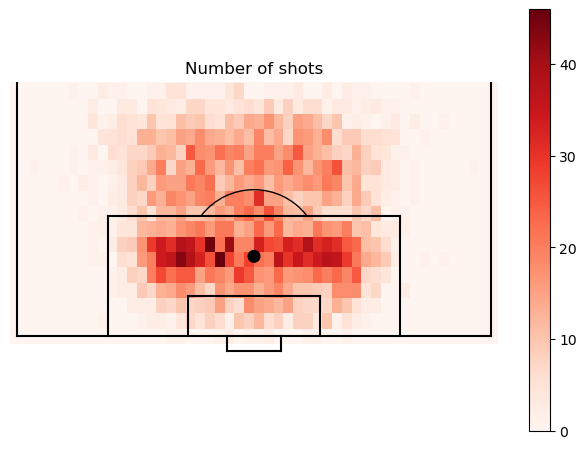

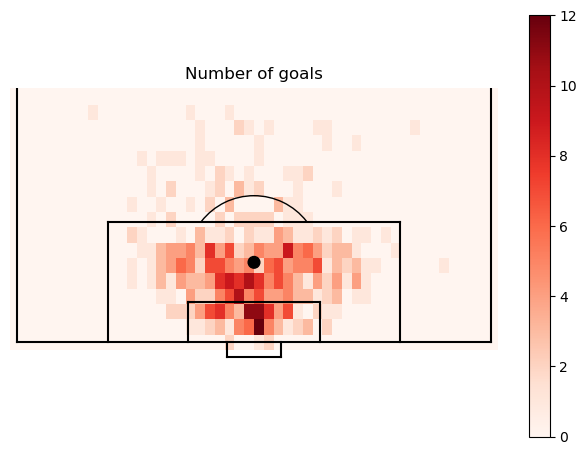

/var/folders/1r/56nf11_90f52p5v071j9flwr0000gp/T/ipykernel_767/1832080266.py:70: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


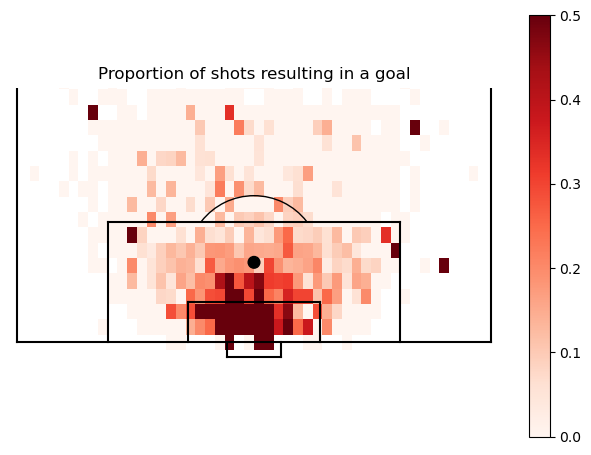

In [61]:
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in df_shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])



#Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")   


#Plot the number of GOALS from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")   


#Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight") 